In [1]:
import scipy.io
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Const

sequence_length = 18000
n_test = 5000
zip_file_path = './data/training2017.zip'


# Utils

def load_ecg(zip_file, file_name):
    with zip_file.open(file_name) as mat_file:
        mat = scipy.io.loadmat(mat_file)
        ecg_data = mat['val'].squeeze()
    return ecg_data

scaler = MinMaxScaler(feature_range=(0, 1))

def normalize_ecg_minmax(ecg_data):
    ecg_data = scaler.fit_transform(ecg_data.reshape(-1, 1)).flatten()
    return ecg_data

def pad_or_trim_ecg(ecg_data, target_length):
    if len(ecg_data) > target_length:
        return ecg_data[:target_length]
    elif len(ecg_data) < target_length:
        return np.pad(ecg_data, (0, target_length - len(ecg_data)), 'constant')
    return ecg_data

class ECGDataset(Dataset):
    def __init__(self, ecg_data, labels):
        self.ecg_data = ecg_data
        self.labels = labels

    def __len__(self):
        return len(self.ecg_data)

    def __getitem__(self, idx):
        ecg = self.ecg_data[idx]
        label = self.labels[idx]
        return torch.tensor(ecg, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [2]:
# Prepare data

df = pd.read_csv('./data/REFERENCE.csv', header=None, names=['file', 'label'])
label_mapping = {'N': 0, 'A': 1, 'O': 2, '~': 3}
df['label'] = df['label'].map(label_mapping)

ecg_files = df['file'].values
ecg_data_list = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    for k in range(n_test):
        file_name = f'training2017/{ecg_files[k]}.mat' 
        ecg_data = load_ecg(zip_file, file_name)
        ecg_data_list.append(ecg_data)

ecg_data_list = [normalize_ecg_minmax(pad_or_trim_ecg(ecg, sequence_length)) for ecg in ecg_data_list]
labels = df['label'].values[:n_test]

In [3]:
# Training CNN

ecg_train, ecg_test, labels_train, labels_test = train_test_split(ecg_data_list, labels, test_size=0.2, random_state=42)

batch_size = 32

train_dataset = ECGDataset(ecg_train, labels_train)
test_dataset = ECGDataset(ecg_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ECGCNN(nn.Module):
    def __init__(self):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(64 * 281, 64)
        self.fc2 = nn.Linear(64, 4)  # 4 classes de sortie

        self.pool = nn.MaxPool1d(4)

    def forward(self, x):
       x = x.unsqueeze(1)
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = self.pool(F.relu(self.conv3(x)))
       
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = self.fc2(x)
       return x


model = ECGCNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad() 
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss / len(train_loader)}")


Epoch 1/5, Loss: 1.0142438859939575
Epoch 2/5, Loss: 0.9984187426567077
Epoch 3/5, Loss: 0.99603076171875
Epoch 4/5, Loss: 0.9802347044944764
Epoch 5/5, Loss: 0.949962173461914


Test Accuracy: 60.90%


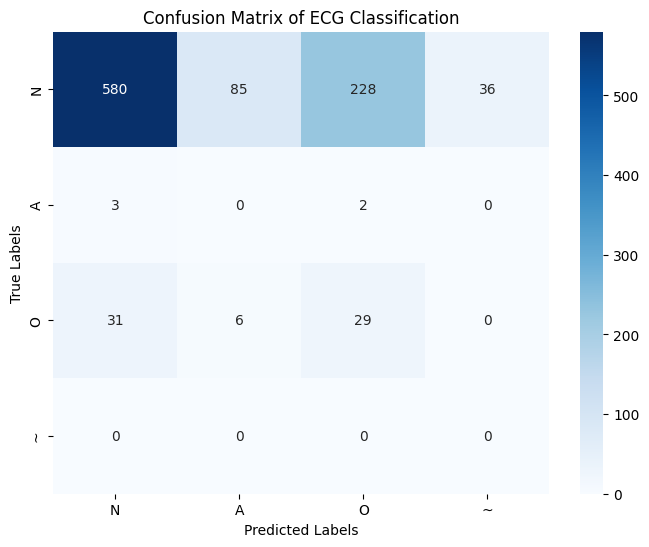

In [4]:
# Evaluation CNN

model.eval() 
correct = 0
total = 0

preds = []
lbls = []



with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted.cpu().numpy())
        lbls.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

cm = cm = confusion_matrix(preds, lbls)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of ECG Classification')
plt.show()


In [5]:
# RNN

labels_rnn = df['label'].values[:n_test]
factor=4

def downsample_ecg_rnn(ecg_data):
    return ecg_data[::factor]

ecg_data_list_rnn = [downsample_ecg_rnn(ecg) for ecg in ecg_data_list]
sequence_length_rnn = sequence_length // factor

ecg_data_list_rnn = [pad_or_trim_ecg(ecg, sequence_length_rnn) for ecg in ecg_data_list_rnn]
ecg_data_list_rnn = [normalize_ecg_minmax(ecg) for ecg in ecg_data_list_rnn]

ecg_train_rnn, ecg_test_rnn, labels_train_rnn, labels_test_rnn = train_test_split(
    ecg_data_list_rnn, labels_rnn, test_size=0.2, random_state=42
)

batch_size_rnn = 64

train_dataset_rnn = ECGDataset(ecg_train_rnn, labels_train_rnn)
test_dataset_rnn = ECGDataset(ecg_test_rnn, labels_test_rnn)

train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=batch_size_rnn, shuffle=True)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=batch_size_rnn, shuffle=False)


class ECGRNN(nn.Module):
    def __init__(self):
        super(ECGRNN, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=32, batch_first=True)
        self.fc1 = nn.Linear(32, 32) 
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):

        x = x.unsqueeze(-1)
        gru_out, _ = self.gru(x)
        out = gru_out[:, -1, :]
        
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Training RNN

modelRNN = ECGRNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(modelRNN.parameters(), lr=0.001)

n_epochs = 5

for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs, labels_rnn) in enumerate(train_loader_rnn):
        optimizer.zero_grad() 
        
        outputs = modelRNN(inputs)
        loss = criterion(outputs, labels_rnn)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss / len(train_loader_rnn)}")


Epoch 1/5, Loss: 1.1680509287213523
Epoch 2/5, Loss: 0.9953257327988034
Epoch 3/5, Loss: 0.9915015735323467
Epoch 4/5, Loss: 0.9924907892469376
Epoch 5/5, Loss: 0.9939981594918266


Test Accuracy: 61.40%


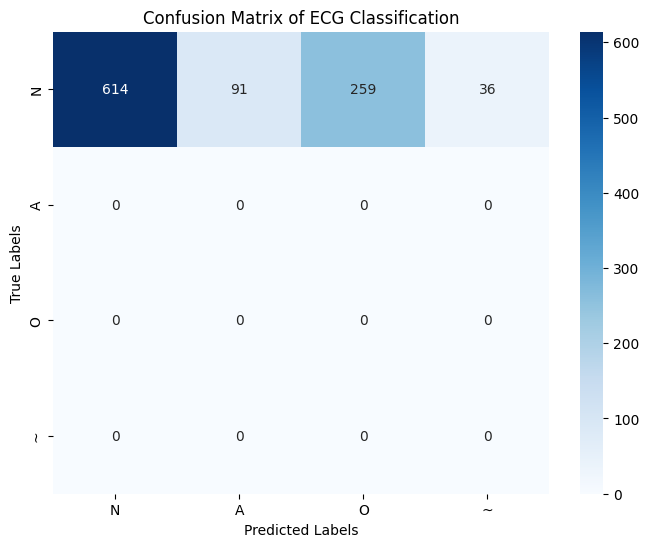

In [6]:
# Evaluation RNN

modelRNN.eval() 
correct = 0
total = 0

preds_rnn = []
lbls_rnn = []

with torch.no_grad():
    for inputs, labels_rnn in test_loader_rnn:
        outputs = modelRNN(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_rnn.size(0)
        correct += (predicted == labels_rnn).sum().item()
        preds_rnn.extend(predicted.cpu().numpy())
        lbls_rnn.extend(labels_rnn.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(preds_rnn, lbls_rnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of ECG Classification')
plt.show()


Surement en raison de la sur-représentation des patients sains (N), nos deux modèles classent de manière "abusive" dans cette catégorie. Les classificateurs ne sont pas suffisament performants. Notre CNN est un peu plus performant que le RNN qui place systématiquement les patients en "N".